# Autonomous Underwater Vehicle Fault Diagnosis

## Model training using Mcfly AutoML

Ji, Daxiong (2021), “Autonomous Underwater Vehicle Fault Diagnosis Dataset”, Mendeley Data, V1, doi: 10.17632/7rp2pmr6mx.1

Dataset source: https://data.mendeley.com/datasets/7rp2pmr6mx/1

## Data preparation

In [2]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sktime.datatypes import convert_to
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from mcfly.modelgen import generate_models
from mcfly.find_architecture import find_best_architecture
from mcfly.find_architecture import train_models_on_samples

warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(42)
SEED=42

In [6]:
data_path = "../data/autonomous-uboot/preprocessed"

# Load X_train
X_train = pd.read_parquet(os.path.join(data_path, "features-train.parquet"))

# Convert the dataframes into numpy arrays
X_train = convert_to(X_train, to_type="numpy3D")

# Swap axes so that Mcfly models can consume the input data
X_train = np.swapaxes(X_train, 1, 2)

# Same previous steps for the test dataset
X_test = pd.read_parquet(os.path.join(data_path, "features-test.parquet"))
X_test = convert_to(X_test, to_type="numpy3D")
X_test = np.swapaxes(X_test, 1, 2)

# Load the labels
y_train = pd.read_csv(os.path.join(data_path, "labels-train.csv"))
y_train = y_train["label"].values

y_test = pd.read_csv(os.path.join(data_path, "labels-test.csv"))
y_test = y_test["label"].values

# Shuffle the dataset
X_train, y_train = shuffle(X_train, y_train, random_state=SEED)
X_test, y_test = shuffle(X_test, y_test, random_state=SEED)

# Encode labels using OneHotEncoder
ohe = OneHotEncoder()
ohe = ohe.fit(y_train.reshape(-1, 1))

y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((975, 180, 16), (245, 180, 16), (975, 5), (245, 5))

In [9]:
# Validation dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.20, 
    random_state=SEED,
    shuffle=True, 
    stratify=y_train
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((780, 180, 16), (195, 180, 16), (780, 5), (195, 5))

In [10]:
print("y_train:", Counter(np.argmax(y_train, axis=1)))
print("y_val:", Counter(np.argmax(y_val, axis=1)))
print("y_test:", Counter(np.argmax(y_test, axis=1)))

y_train: Counter({0: 171, 2: 170, 4: 166, 3: 159, 1: 114})
y_val: Counter({2: 43, 0: 43, 4: 41, 3: 39, 1: 29})
y_test: Counter({0: 54, 2: 53, 4: 52, 3: 50, 1: 36})


## Class weights

In [11]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(y_train, axis=1)),
    y = np.argmax(y_train, axis=1)                                                    
)

class_weights = dict(zip(np.unique(np.argmax(y_train, axis=1)), class_weights))
class_weights

{0: 0.9122807017543859,
 1: 1.368421052631579,
 2: 0.9176470588235294,
 3: 0.9811320754716981,
 4: 0.9397590361445783}

## Model training 

In [13]:
%%time

file_name = f"model-comparison-20220811.json"
output_file = os.path.join("../data/mcfly-models-uboot", file_name)
model_path = os.path.join("../data/mcfly-models-uboot")

models = generate_models(
    X_train.shape, 
    y_train.shape[1],
    number_of_models=5,
    metrics=["accuracy"],
    model_types=['CNN', 'ResNet', 'InceptionTime'],
)

history, val_metrics, val_losses = train_models_on_samples(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models=models,
    nr_epochs=30,
    verbose=True,
    model_path=model_path,
    outputfile=output_file,
    subset_size=X_train.shape[0],
    early_stopping_patience=5,
    class_weight=class_weights
)

Generated models will be trained on subset of the data (subset size: 780).
Training model 0 CNN
Epoch 1/30
39/39 [==============================] - 3s 31ms/step - loss: 3.0432 - accuracy: 0.7885 - val_loss: 141.5310 - val_accuracy: 0.2000
Epoch 2/30
39/39 [==============================] - 1s 18ms/step - loss: 2.1603 - accuracy: 0.8949 - val_loss: 104.3959 - val_accuracy: 0.2000
Epoch 3/30
39/39 [==============================] - 1s 18ms/step - loss: 1.4152 - accuracy: 0.9333 - val_loss: 25.1760 - val_accuracy: 0.2000
Epoch 4/30
39/39 [==============================] - 1s 18ms/step - loss: 1.0279 - accuracy: 0.9628 - val_loss: 25.3965 - val_accuracy: 0.2000
Epoch 5/30
39/39 [==============================] - 1s 19ms/step - loss: 0.7896 - accuracy: 0.9923 - val_loss: 9.9897 - val_accuracy: 0.2051
Epoch 6/30
39/39 [==============================] - 1s 18ms/step - loss: 0.6965 - accuracy: 0.9641 - val_loss: 10.8925 - val_accuracy: 0.2000
Epoch 7/30
39/39 [==============================] -

39/39 [==============================] - 2s 64ms/step - loss: 0.0819 - accuracy: 0.9808 - val_loss: 0.5963 - val_accuracy: 0.8359
Epoch 24: early stopping
Training model 3 CNN
Epoch 1/30
39/39 [==============================] - 4s 40ms/step - loss: 1.4649 - accuracy: 0.8218 - val_loss: 118.2082 - val_accuracy: 0.2000
Epoch 2/30
39/39 [==============================] - 1s 30ms/step - loss: 1.1672 - accuracy: 0.9295 - val_loss: 60.2941 - val_accuracy: 0.1487
Epoch 3/30
39/39 [==============================] - 1s 29ms/step - loss: 0.9589 - accuracy: 0.9769 - val_loss: 37.1233 - val_accuracy: 0.2000
Epoch 4/30
39/39 [==============================] - 1s 30ms/step - loss: 0.8111 - accuracy: 0.9949 - val_loss: 4.8138 - val_accuracy: 0.2615
Epoch 5/30
39/39 [==============================] - 1s 30ms/step - loss: 0.7169 - accuracy: 0.9923 - val_loss: 8.2248 - val_accuracy: 0.1487
Epoch 6/30
39/39 [==============================] - 1s 30ms/step - loss: 0.6567 - accuracy: 0.9859 - val_loss: 3.41

39/39 [==============================] - 2s 63ms/step - loss: 0.0759 - accuracy: 0.9718 - val_loss: 1.1428 - val_accuracy: 0.8256
Epoch 28/30
39/39 [==============================] - 2s 61ms/step - loss: 0.0733 - accuracy: 0.9731 - val_loss: 0.4792 - val_accuracy: 0.8821
Epoch 29/30
39/39 [==============================] - 2s 63ms/step - loss: 0.0310 - accuracy: 0.9923 - val_loss: 1.2749 - val_accuracy: 0.7949
Epoch 30/30
39/39 [==============================] - 2s 64ms/step - loss: 0.0268 - accuracy: 0.9910 - val_loss: 0.1581 - val_accuracy: 0.9538
CPU times: total: 5min 7s
Wall time: 4min 6s


In [14]:
best_model_index = np.argmax(val_metrics["accuracy"])
best_model, best_params, best_model_type = models[best_model_index]

print("Best model type:", best_model_type)

Best model type: ResNet


## Model training history plots

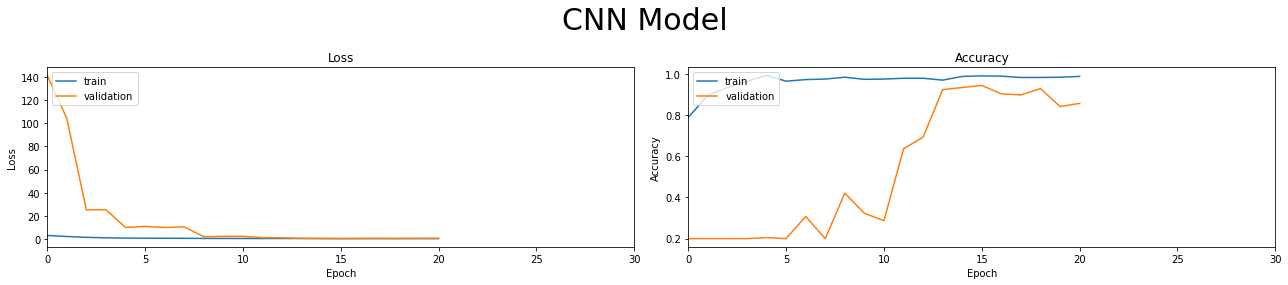

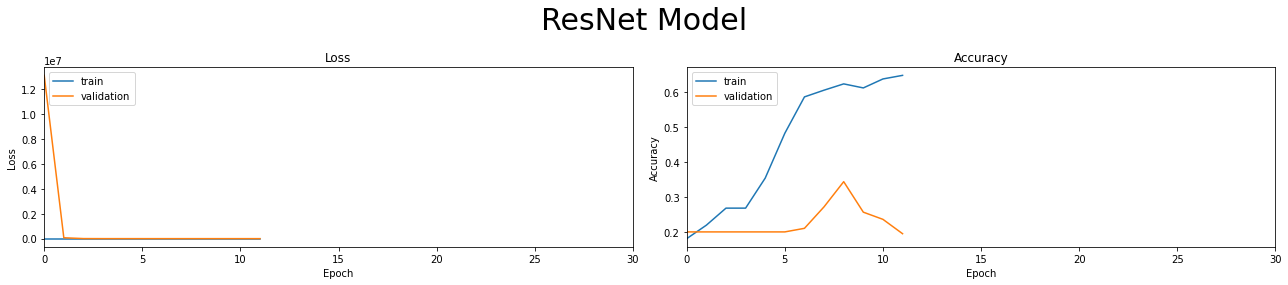

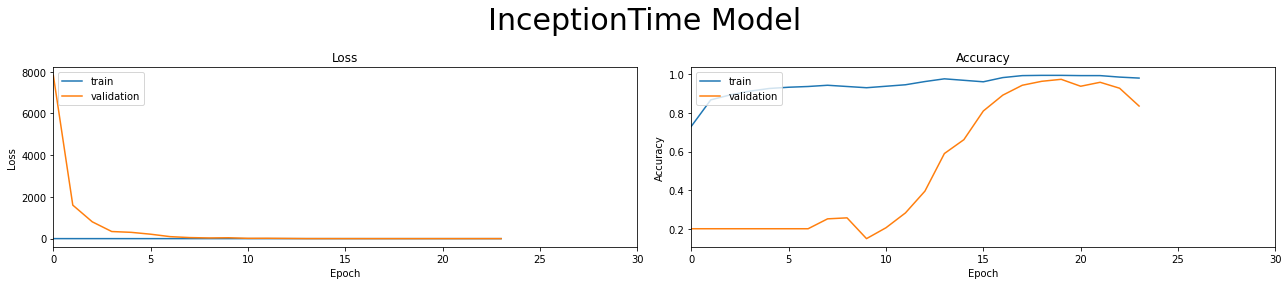

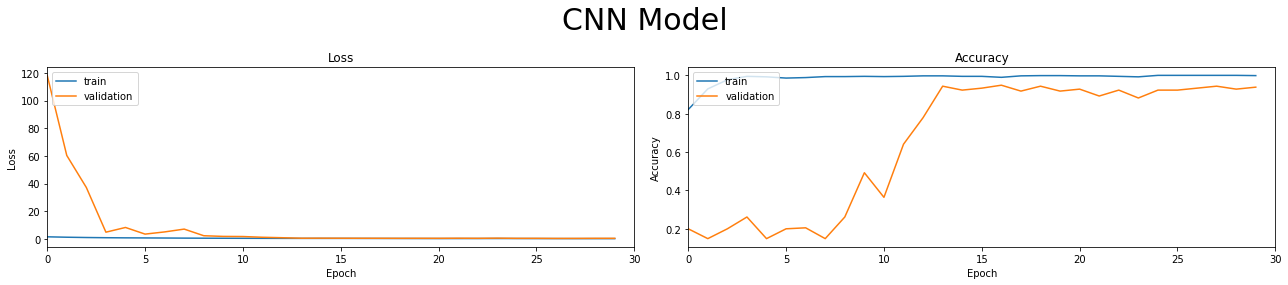

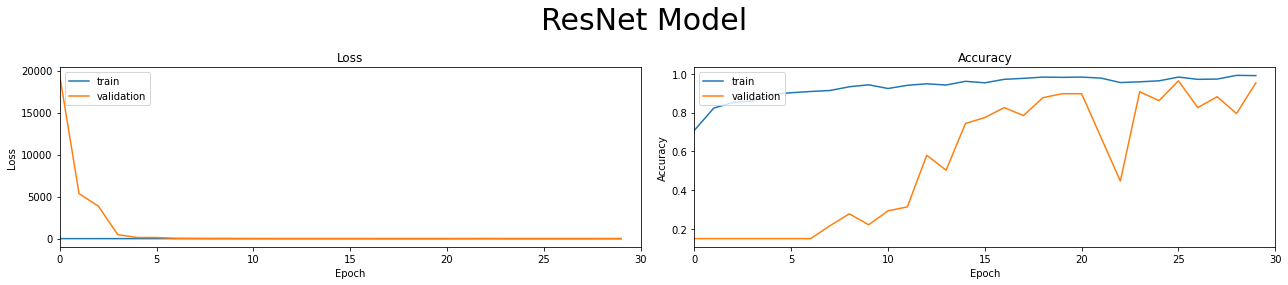

In [15]:
model_types = list(map(lambda m: m[2],models))

for i in range(len(model_types)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 4))

    fig.suptitle(f"{model_types[i]} Model", fontsize=30)

    ax1.plot(history[i].history['loss'])
    ax1.plot(history[i].history['val_loss'])
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    ax1.set_xlim([0, 30])

    ax2.plot(history[i].history['accuracy'])
    ax2.plot(history[i].history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    ax2.set_xlim([0, 30])

    plt.tight_layout()
    plt.show()

### Train the best model (ResNet) on the full training dataset

In [ ]:
%%time

history = best_model.fit(
    X_train, 
    y_train,
    epochs=20, 
    validation_data=(X_val, y_val),
)

### ResNet model evaluation

In [18]:
%%time

y_pred = best_model.predict(X_test, batch_size=1)

245/245 [==============================] - 2s 6ms/step
CPU times: total: 2.25 s
Wall time: 2.66 s


In [19]:
print(f"Classification report for the {best_model_type} model:\n")
print(
    classification_report(
        np.argmax(y_test, axis=1), 
        np.argmax(y_pred, axis=1),
        digits=4
    )
)

Classification report for the ResNet model:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        54
           1     0.8250    0.9167    0.8684        36
           2     0.9815    1.0000    0.9907        53
           3     1.0000    0.8200    0.9011        50
           4     0.8750    0.9423    0.9074        52

    accuracy                         0.9388       245
   macro avg     0.9363    0.9358    0.9335       245
weighted avg     0.9437    0.9388    0.9388       245



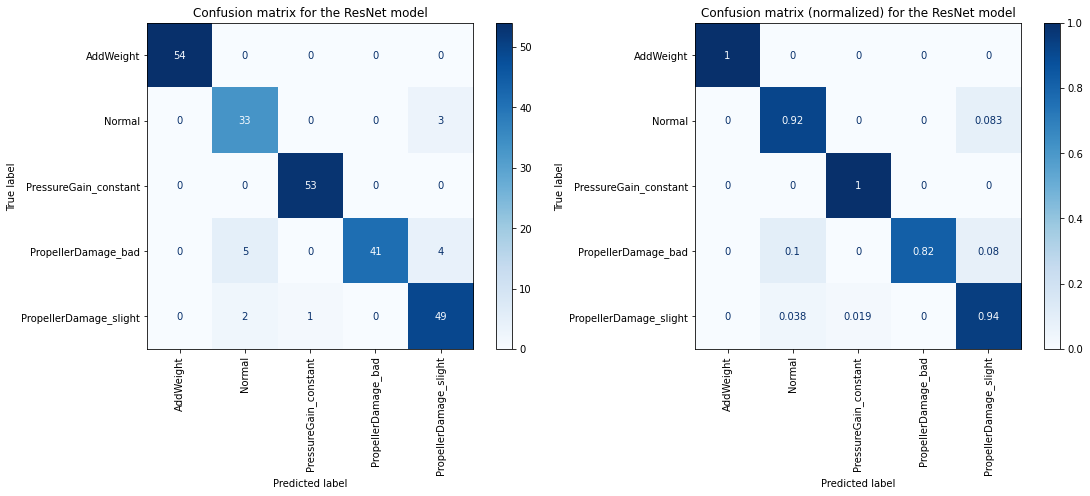

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    xticks_rotation="vertical",
    normalize=None,
    cmap="Blues",
    ax=ax1
)
ax1.set_title(f"Confusion matrix for the {best_model_type} model")

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    xticks_rotation="vertical",
    normalize="true",
    cmap="Blues",
    ax=ax2
)
ax2.set_title(f"Confusion matrix (normalized) for the {best_model_type} model")

plt.show()